In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

2025-07-14 11:09:59.947125: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-14 11:10:00.080760: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-14 11:10:00.085209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-07-14 11:10:00.085226: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
SAMPLING_RATE = 12000 # Частота дискретизации 
WINDOW_SIZE = 4096 # Размер фрейма для дробления исходных данных   
STEP = 2048 # Шаг фрейма


NPERSEG = 2048  # Размер фрейма для создания спектрограммы            
NOVERLAP = NPERSEG - 1 #коэф наложения фрейма

DPI = 100 # Количество точек на дюйм для изображения
IMG_HEIGHT = 257  # Высота изображения 
IMG_WIDTH = 3585 # Ширина изображения
CLASS_NAMES = ['defect', 'normal'] # Классы модели, важен порядок (смотри train.ipynb)

In [4]:
def create_spectrogram_from_chunk_normalized(chunk_data, fs):
    """
    Создает нормализованную спектрограмму из фрагмента данных в памяти, не сохраняя на диск.
    Возвращает изображение в виде numpy-массива.
    """
    frequencies, times, Zxx = signal.stft(
        chunk_data, 
        fs=fs, 
        nperseg=NPERSEG, 
        noverlap=NOVERLAP, 
        boundary=None
    )
    Zxx_abs = np.abs(Zxx)
    min_val = np.min(Zxx_abs)
    max_val = np.max(Zxx_abs)
    if max_val > min_val:
        Zxx_normalized = (Zxx_abs - min_val) / (max_val - min_val)
    else:
        Zxx_normalized = np.zeros_like(Zxx_abs)
    height, width = IMG_HEIGHT, IMG_WIDTH # Zxx_normalized.shape
    dpi = DPI
    fig_size = (width / dpi, height / dpi)
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(Zxx_normalized, cmap='gray', origin='lower', aspect='auto')
    fig.canvas.draw()
    buf = fig.canvas.buffer_rgba()
    img_array = np.frombuffer(buf, dtype=np.uint8).reshape(fig.canvas.get_width_height()[::-1] + (4,))
    img_array_rgb = img_array[:, :, :3]
    plt.close(fig)
    return img_array_rgb

In [5]:
def evaluate_model(test_data_dir, model_path):
    """
    Основная функция для оценки модели на тестовом наборе данных.
    """
    print(f"Загрузка модели из: {model_path}")
    try:
        model = tf.keras.models.load_model(model_path)
    except Exception as e:
        print(f"Ошибка при загрузке модели: {e}")
        return

    y_true = []  
    y_pred = []  

    for label in CLASS_NAMES:
        class_dir = os.path.join(test_data_dir, label)
        if not os.path.isdir(class_dir):
            print(f"ПРЕДУПРЕЖДЕНИЕ: Директория для класса '{label}' не найдена, пропускаем.")
            continue

        print(f"\nОбработка файлов для класса: '{label}'...")
        for filename in os.listdir(class_dir):
            if filename.endswith('.csv'):
                file_path = os.path.join(class_dir, filename)
                print(f"  -> Файл: {filename}")
                
                try:
                    df = pd.read_csv(file_path)
                    if 'vibration' not in df.columns:
                        print(f"    ПРЕДУПРЕЖДЕНИЕ: В файле {filename} нет колонки 'vibration'. Пропускаем.")
                        continue
                    
                    signal_data = df['vibration'].values
                    
                    chunk_predictions = []
                    for i in range(0, len(signal_data) - WINDOW_SIZE + 1, STEP):
                        chunk = signal_data[i:i + WINDOW_SIZE]
                        spectrogram_img = create_spectrogram_from_chunk_normalized(chunk, SAMPLING_RATE)
                        img_tensor = tf.expand_dims(spectrogram_img, 0)
                        
                        prediction = model.predict(img_tensor, verbose=0)
                        score = tf.nn.sigmoid(prediction[0][0])
                        predicted_class = CLASS_NAMES[1] if score > 0.5 else CLASS_NAMES[0]
                        chunk_predictions.append(predicted_class)
                    if 'defect' in chunk_predictions:
                        final_prediction = 'defect'
                    else:
                        final_prediction = 'normal'
                        
                    y_true.append(label)
                    y_pred.append(final_prediction)

                except Exception as e:
                    print(f"    ОШИБКА при обработке файла {filename}: {e}")

    if not y_true:
        print("\nНе удалось обработать ни одного файла. Проверьте структуру папок и формат данных.")
        return

    print("\n--- ОТЧЕТ О КАЧЕСТВЕ МОДЕЛИ ---")
    
    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES)
    print("Отчет по классификации:")
    print(report)
    
    print("Матрица ошибок (Confusion Matrix):")
    cm = confusion_matrix(y_true, y_pred, labels=CLASS_NAMES)
    print(cm)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Матрица ошибок')
    plt.show()

2025-07-14 11:10:01.265463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Загрузка модели из: model.keras

Обработка файлов для класса: 'defect'...
  -> Файл: B007_0.csv
  -> Файл: B007_1.csv
  -> Файл: B007_2.csv
  -> Файл: B007_3.csv

Обработка файлов для класса: 'normal'...
  -> Файл: Normal_1.csv
  -> Файл: Normal_2.csv

--- ОТЧЕТ О КАЧЕСТВЕ МОДЕЛИ ---
Отчет по классификации:
              precision    recall  f1-score   support

      defect       1.00      1.00      1.00         4
      normal       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

Матрица ошибок (Confusion Matrix):
[[4 0]
 [0 2]]


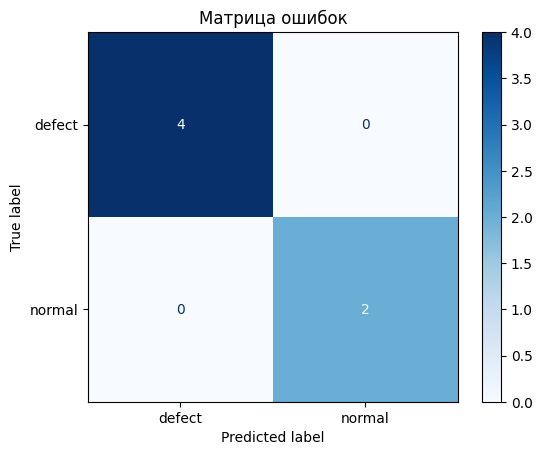

In [6]:

# Укажите путь к папке с вашими тестовыми CSV файлами
PATH_TO_TEST_DATASET = 'csv_cwru_data'

# Укажите путь к вашей обученной модели
PATH_TO_MODEL = 'model.keras'

if not os.path.exists(PATH_TO_TEST_DATASET):
    print(f"Тестовый датасет не найден: {PATH_TO_TEST_DATASET}. Укажите правильный путь.")
elif not os.path.exists(PATH_TO_MODEL):
        print(f"Модель не найдена: {PATH_TO_MODEL}. Укажите правильный путь.")
else:
    evaluate_model(PATH_TO_TEST_DATASET, PATH_TO_MODEL)
